# Compressed Sensing Examples

In [3]:
!pip install cvxpy

In [4]:
import numpy as np
import cvxpy as cvx
import scipy as sp

import matplotlib.pyplot as plt

## Example 1: Superposition of two sine waves

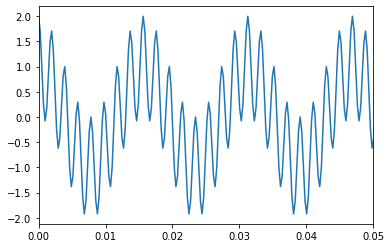

In [5]:
def f(t):
  return 1*np.cos(64 * 2*np.pi*t) + 1*np.cos(512 * 2*np.pi*t)

def plot_function(f):
  n = 4096
  t = np.arange(0,1,1/n)

  plt.plot(t, f(t))
  plt.xlim(0, 0.05)
  plt.show()

plot_function(f)

### Plot Power Spectrum Density

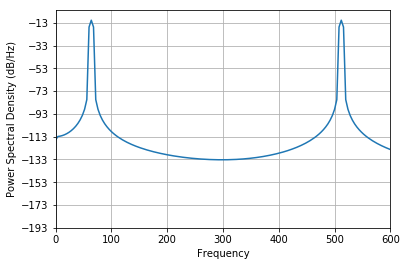

In [ ]:
plt.psd(f(t), 1024, 4096)
plt.xlim(0,600)
plt.show()

### Take random measurements

(128, 4096)
(4096,)
(128,)
[3810 3509 3643 1821 2203 2607 1351  580 1472 2531 2527 2861 2864 1983
 2127 3345  506 2966 2019 3606 3356 1385  526  323  389 1129 3641 1611
 2111 1737  500 2822  484   39  420 1939  770 3816 3022 1438  355  825
 2868 2462 1447 2947 3471 2033  705 3156 1617  606 3631 1892 1117 3063
 3056  895 1606  926 2951 1596 1798 1080  471  547 1716 1538 1419 2598
  782 2984 3235 2493  500  291 3421 1635 2917 2057  908 1161 1197 2072
   22 3304 1040 1736 1208  836 3122 1520  661 2897 2925 1278 1007 3975
 3319  972  976  796  610 2886  203  753 2348 1052  860 1864  644 2401
 3689   71 3807 1356 1142 2447 3906  299 2648 3138 1993 1256 3474 1484
 1399 3264]


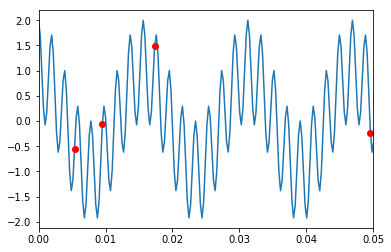

In [ ]:
#sample_points = np.round(np.random.rand(64)*n)/n
#sample_values = f(sample_points)

k = 128
j = 1
Phi = np.array([np.array([1]*j + [0]*(n-j)) for _ in range(k)])
for arr in Phi:
  np.random.shuffle(arr)
print(Phi.shape)

ft = np.array(f(t))
print(ft.shape)

v = np.matmul(Phi, ft)
print(v.shape)

Phi_points = np.array([np.argmax(row) for row in Phi])
print(Phi_points)

plt.plot(t, f(t))
#plt.plot(sample_points, sample_values, 'ro')
plt.plot(Phi_points/n, v, 'ro')
plt.xlim(0, 0.05)
plt.show()

### Reconstruct f from random sample

In [ ]:
# Magic begins here

def base_vector(n, k):
  return np.eye(1,n,k)[0]

Psi = np.array([np.fft.fft(base_vector(n,k)) for k in range(n)])

A = np.matmul(Phi, Psi)
print(np.linalg.matrix_rank(A))

x = cvx.Variable(n) #n is dim x  
objective = cvx.Minimize(cvx.norm(x,1)) #L_1 norm objective function
constraints = [A*x == v]
prob = cvx.Problem(objective,constraints)
result = prob.solve(verbose=False)

print(result)

127
1.9092411388875283


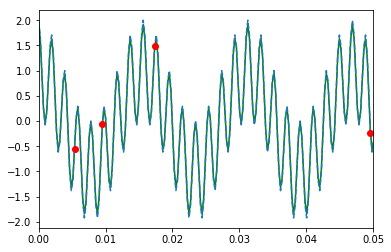

In [ ]:
plt.plot(t, n*np.real(np.fft.ifft(x.value)), 'g')

plt.plot(t, f(t), '--')
#plt.plot(sample_points, sample_values, 'ro')
plt.plot(Phi_points/n, v, 'ro')
plt.xlim(0, 0.05)
plt.show()

## 1-Pixel Pictures

1.0

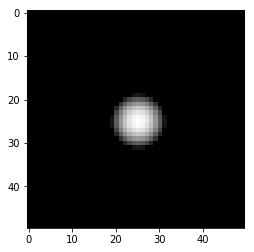

In [ ]:
pic = 0.01* np.round(np.random.rand(50,50))
for x in range(50):
  for y in range(50):
    if ((x-25)**2 + (y-25)**2 < 40):
      pic[x,y] += 40 - ((x-25)**2 + (y-25)**2)
      
pic /= np.max(pic)
plt.imshow(pic, cmap='gray')

np.max(pic)

0.0001999500124968758

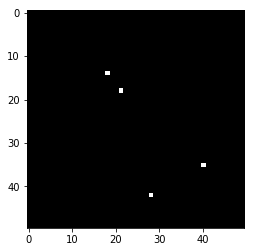

In [ ]:
height = width = 50

def random_mask(height, width, k):
  mask = np.array([0]*(height*width-k) + [1]*k)
  np.random.shuffle(mask)
  return mask.reshape(height, width)
  
mask = random_mask(height, width, 5)

plt.imshow(mask*pic, cmap='gray')
np.sum(mask*pic)/5

In [ ]:
k = 10

masks = [random_mask(height, width, k) for i in range(400)]
Phi = np.array([(mask/k).flatten('F') for mask in masks])

v = np.matmul(Phi, pic.flatten('F'))

def base_matrix(n, k):
  return (np.eye(1,n*n,k)[0]).reshape(n,n).transpose()

Psi = np.array([np.fft.fft2(base_matrix(height,k)).flatten('F') for k in range(height**2)])

Theta = np.matmul(Phi, Psi)
Theta.shape

np.linalg.matrix_rank(Theta)

400

In [ ]:
# Magic begins here

A = Theta

x = cvx.Variable(height*width, complex=True) #n is dim x

objective = cvx.Minimize(cvx.norm(x,1)) #L_1 norm objective function
constraints = [A*x==v]
prob = cvx.Problem(objective,constraints)
result = prob.solve(verbose=True)

print(result)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+04  1e+00  6e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -2.003e+00  +6.749e-04  +3e+03  4e-01  8e-02  2e+00  4e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -1.887e-01  +2.631e-03  +2e+02  2e-01  4e-03  2e-01  2e-02  0.9496  9e-03   1  1  1 |  0  0
 3  +3.996e-02  +4.800e-02  +7e+01  1e-01  1e-03  1e-02  9e-03  0.9890  4e-01   2  2  2 |  0  0
 4  +8.774e-02  +9.298e-02  +4e+01  9e-02  9e-04  7e-03  6e-03  0.3655  1e-01   2  2  2 |  0  0
 5  +2.429e-01  +2.429e-01  +2e+01  5e-02  4e-04  8e-04  3e-03  0.9890  4e-01   2  2  2 |  0  0
 6  +5.407e-01  +5.408e-01  +1e+01  4e-02  3e-04  7e-04  2e-03  0.4336  1e-01   2  2  2 |  0  0
 7  +5.552e-01  +5.552e-01  +1e+01  3e-02  3e-04  5e-04  1e-03  0.3568  8e-01   2  3  2 |  0  0
 8  +7.788e-01  +7.788e-01  +7e+00  2e-02  2e-

207.11865471335153 -22.24844968208305


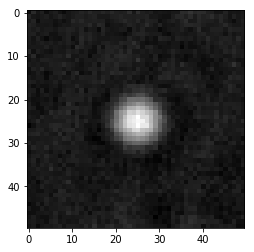

In [ ]:
xr = x.value.reshape(height, width).transpose()
rec = 256*height*width*np.real(np.fft.ifft2(xr))

plt.imshow(np.round(rec), cmap='gray')

print(np.max(rec), np.min(rec))

## Lena

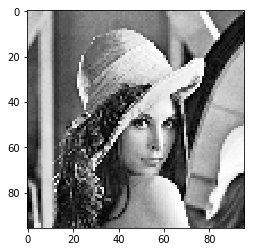

In [ ]:
url='http://bussnova.com/wp-content/uploads/gestalt-theory-examples-gestalt-theory-examples-12-images-art-sego.jpg'
url='https://www.csie.ntu.edu.tw/~r93944019/cv/hw3/lena_after.jpg'

from PIL import Image
import requests
from io import BytesIO
import cv2

response = requests.get(url)
pic = np.array(Image.open(BytesIO(response.content)))
pic = cv2.resize(pic, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
pic = pic/np.max(pic)

plt.imshow(pic, cmap='gray')

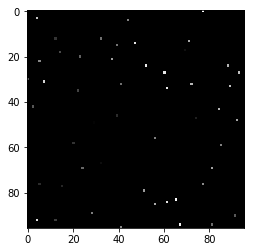

In [ ]:
height, width = pic.shape

def random_mask(height, width, k):
  mask = np.array([0]*(height*width-k) + [1]*k)
  np.random.shuffle(mask)
  return mask.reshape(height, width)
  
mask = random_mask(height, width, 50)

plt.imshow(mask*pic, cmap='gray')
#np.sum(mask*pic)/5

In [ ]:
k = 50

masks = [random_mask(height, width, k) for i in range(2000)]
Phi = np.array([(mask/k).flatten('F') for mask in masks])

v = np.matmul(Phi, pic.flatten('F'))

def base_matrix(n, k):
  return (np.eye(1,n*n,k)[0]).reshape(n,n).transpose()

Psi = np.array([np.fft.fft2(base_matrix(height,k)).flatten('F') for k in range(height**2)])

Theta = np.matmul(Phi, Psi)
Theta.shape

np.linalg.matrix_rank(Theta)

2000

In [ ]:
# Magic begins here

A = Theta
delta = 0.05*np.max(v)/height

x = cvx.Variable(height*width, complex=True) #n is dim x  
objective = cvx.Minimize(cvx.norm(x,1)) #L_1 norm objective function
constraints = [A*x==v]
prob = cvx.Problem(objective,constraints)
result = prob.solve(verbose=True)

print(result)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +4e+04  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.921e+00  +7.225e-02  +1e+04  4e-01  9e-02  2e+00  5e-01  0.9330  3e-01   1  1  1 |  0  0
 2  -1.040e+00  +6.328e-01  +1e+04  4e-01  9e-02  2e+00  5e-01  0.2666  7e-01   1  1  2 |  0  0
 3  +1.402e-01  +4.531e-01  +5e+03  3e-01  2e-02  4e-01  2e-01  0.9890  3e-01   1  1  1 |  0  0
 4  +5.296e-01  +5.603e-01  +5e+02  1e-01  2e-03  3e-02  2e-02  0.9026  9e-03   1  1  1 |  0  0
 5  +9.704e-01  +9.711e-01  +1e+02  3e-02  7e-04  2e-03  5e-03  0.9890  3e-01   2  2  2 |  0  0
 6  +1.652e+00  +1.653e+00  +1e+02  3e-02  6e-04  2e-03  4e-03  0.2677  3e-01   2  2  2 |  0  0
 7  +2.064e+00  +2.065e+00  +1e+02  3e-02  5e-04  1e-03  4e-03  0.2231  7e-01   2  2  2 |  0  0
 8  +2.824e+00  +2.825e+00  +8e+01  3e-02  4e-

326.2564668929804 -57.984453301337595


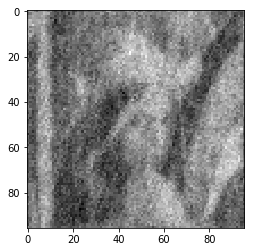

In [ ]:
xr = x.value.reshape(height, width).transpose()

rec = 256*height*width*np.real(np.fft.ifft2(xr))

#TODO: I messed up some transformation, so the image is rotated by 180 degrees
rec = np.rot90(rec, 2)

plt.imshow(np.round(rec), cmap='gray')

print(np.max(rec), np.min(rec))